In [9]:
import sys  
sys.path.insert(0, '/home/sam/Code/motorai_challenge/')
import cv2
from utils.preprocessing import crop, resize, black_white, plot_images, process_image

# 1. Dataset
    - Own dataset.
    - No pretrained models for gesture recognition.


### 1.a What gestures you used and why you chose those specific gestures?

Considering the fact that we need a very optimized model to do real-time inference to control the gym environment we need to simplify the learning task as much as possible so that a simple model could be powerful enough to achieve good performance. 

To achieve this goal we need gestures that fulfill the following criteria:
 * **Very different from one another**: The more obvious the difference in gestures the easier they are to learn. A simple model would have difficulties trying to learn small nuances in hand positions or other type of complicated gestures. 
 * **Easy to transition quickly between them**: Intermediate positions are noisy and should be avoided.
 * Easy to make with small variations between attempts: If a specific hand gesture is hard to make or its shape can be varied in many different ways the model would need more data to learn each gesture reliably.
 * **Small and easy to crop**: If the gesture takes too munch of the image we will be limited when trying to crop the image to decrease the input size.
 * **Easy to make with one hand in the center of the chest**: The shirt provides an uniform background which reduces the noise around the relevant gesture. The more complicated the background of the scene the more data is needed to learn to separate background from gesture.

According to this criteria the following gestures are good options:

 * **Vertical hand**   -> `accelerate to the left`.
 * **Horizontal hand** -> `accelerate to the right`.
 * **No gesture**     -> `don't accelerate`.
 
The reasoning is that horizontal and vertical edges are arguably the most basic features in a image and are picked up quickly by the first layers of the network which means that not many layers are needed and hence the architecture remains simple and small :).
 

### 1.b Explain the design strategies you used to create the dataset
With the gestures already defined mainly with inference speed in mind we need a **preprocessing pipeline** that further contributes to this purpose by simplyfing the input space as much as possible while retaining the relevant information.

With this in mind the following steps were defined:
 * **Convert image to grayscale**: This reduces the number of channels in the image from 3 to 1, effectively making the input 3 times smaller.
 * **Crop the borders of the image**: This reduces the noise introduced by objects/shapes close to the edges of the image.
 * **Resize the image to 64x64**: Due to the simplicity of the gestures the important information (i.e. vertical and horizontal edges) is kept even after downscaling the image significantly. By downscaling to a fixed size instead to a percentage of the original input shape we allow the system to work with any original resolution.
 * **Convert image to black&white***: By reducing the possible pixel values to 0 and 255 we are drasically reducing the size of the input space. Specifically we bring the number of possible inputs from 256^(64x64) to 2^(64x64). Probably more important is the fact that this also considerably reduces the noise in the image since all the pixels with values below a specific threshold will be mapped to black.
 
Considering the limited time to solve this challenge it is also important to design a **very efficient data collection and labelling strategy**. The following were the two main ideas regarding this:
  * **Record a video for each gesture and extract the frames**: This is much more efficient than indivually taking pictures of each gesture. It also more realistically represents the application domain where at inference time the model will be receiving a stream of consecutive frames.
  * **Store the frames from each video in a folder with the gesture name and label automatically**: Labelling data is usually one of the most time consuming steps, luckily the problem setting is simple enough to allow for this shortcut. 
  
 The following cell displays one example for each gesture and the result of each processing step:

Accelerate left command


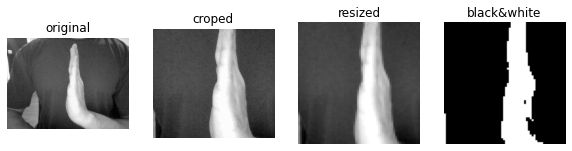

Accelerate right command


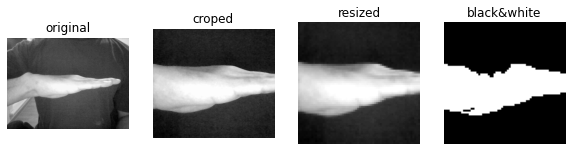

Wait command


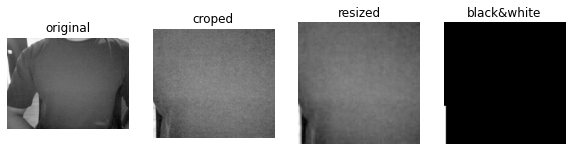

original image shape: (480, 640)
croped image shape: (288, 320)
resized image shape: (64, 64)


In [11]:
left_im = cv2.imread('examples/left_example.jpg', cv2.IMREAD_GRAYSCALE)
left_im_croped = crop(left_im)
left_im_resized = resize(left_im_croped)
left_im_bw = black_white(left_im_resized)
left_images = [left_im, left_im_croped, left_im_resized, left_im_bw]

right_im = cv2.imread('examples/right_example.jpg', cv2.IMREAD_GRAYSCALE)
right_im_croped = crop(right_im)
right_im_resized = resize(right_im_croped)
right_im_bw = black_white(right_im_resized)
right_images = [right_im, right_im_croped, right_im_resized, right_im_bw]

wait_im = cv2.imread('examples/wait_example.jpg', cv2.IMREAD_GRAYSCALE)
wait_im_croped = crop(wait_im)
wait_im_resized = resize(wait_im_croped)
wait_im_bw = black_white(wait_im_resized)
wait_images = [wait_im, wait_im_croped, wait_im_resized, wait_im_bw]

titles = ["original", "croped", "resized", "black&white"]
print("Accelerate left command")
plot_images(left_images, titles)
print("Accelerate right command")
plot_images(right_images, titles)
print("Wait command")
plot_images(wait_images, titles)

# resize image
print(f"original image shape: {left_im.shape}")
print(f"croped image shape: {left_im_croped.shape}")
print(f"resized image shape: {left_im_resized.shape}")

### 1.c What risks are you aware of in your dataset: where it might fail and why?

Each transformation applied to simplify the input also implies losing information. In this case the color information lost when gayscaling and resultion lost when resizing are not important for the task, so they (probably) don't decrease the quality of the dataset. However, the other two transformations do come with a trade-off:
 * **cropping**: This forces the user to a limited area when showing the gesture to the camera at application time. So if the gesture is to close to the edges of the visual field of the camera it will be lost after processing.
 * **black&white**: This method relies on the assumption that the side of the hand is brighter than the background and that the background is not brigther than the threshold used when converting the image. Hence for very clear backgrounds (e.g. white T-shirt or very bright outdoor image on a sunny day) the processed image might be very noisy resulting in wrong predictions. I assume the method works for multiple skin colors since the gesture implies showing the side of the hand which is part of the palm which lacks melanine in all humans so even for darker skins the side of the hand holded closed enough to the camera should be brighter than the background. 
 
Another problem with the dataset is that the images corresponding to the wait class are too clean (as can be seen in section 1.e), they don't capture the possible noise that can be found at application time. The consequence is that if there is a reflection on the shirt or the person moves too much to the sides the model will be easily confused in and probably predict either `right` or `left` in some frames. 

A solution to this problem would be to replace the `wait` samples in the dataset with newly created, more noisy images and then train again. Instead of replacing and loosing the old data it might be better to simply extend the dataset with the new images and retrain.


### 1.d What were the difficulties you faced and how did you overcome them? (If therewere any difficulties)
The main difficulty was dealing with the noise caused by the brightness of the scene when testing the system with clear T-shirts or sunny background.

One way to tackle this problem was to use adaptive thresholding instead of using a threshold with fixed minimum and maximum pixel values. In adaptive thresholding the average brightness of the scene is calculated and only pixiels brigther than the average (and a tunable constant C) are mapped to 255. This makes the system much more robust to brightness and low contrast conditions.

An example of this is shown in the image below where the image on the bottom left used a constant threshold and on the one on the right used adaptive thresholding. The image on the upper center is the original image taken.
![alt text](examples/adaptive_thresholding_left.png "Title")

### 1.e  Describe the properties and statistics about the dataset

The dataset consists of 1800 64x64 black and white images in 3 classes, with 600 images per class.

The cell below shows 80 random samples per class.

class: 'left'


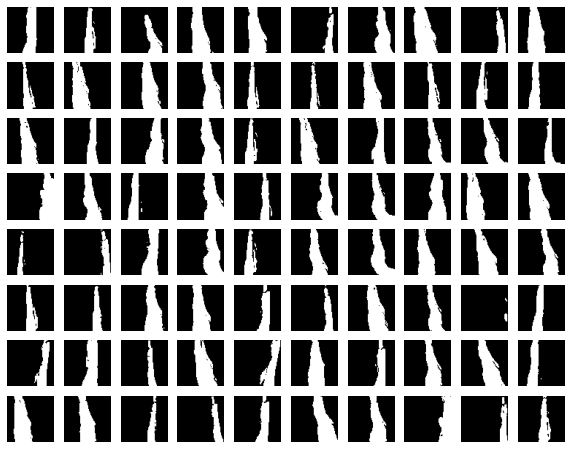

class: 'right'


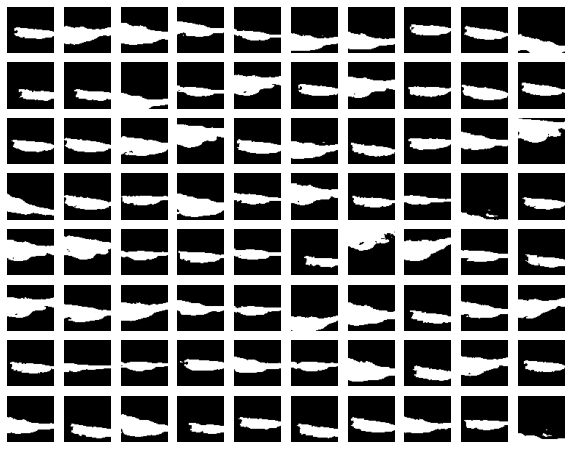

class: 'wait'


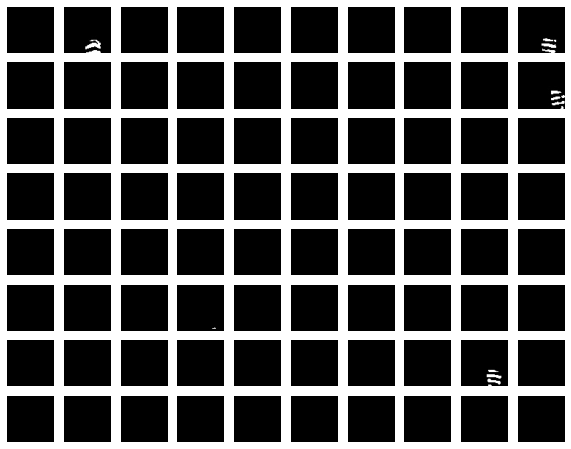

In [33]:
def display_images(n_rows, n_cols, class_name):
    files = random.sample(list(os.listdir(os.path.join(env.images_processed_path, class_name))), n_rows*n_cols)
    fig, axarr = plt.subplots(n_rows, n_cols, figsize=(10,8))
    file_idx = 0
    print(f"class: '{class_name}'")
    for row in range(n_rows):
        for col in range(n_cols):
            filename = os.path.join(env.images_processed_path, class_name, files[file_idx])
            im = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
            axarr[row][col].imshow(im, cmap=plt.cm.gray)
            axarr[row][col].axis("off")
            file_idx += 1
    plt.show()

rows, cols = 8, 10
for class_name in ['left', 'right', 'wait']:
    display_images(rows, cols, class_name)

# 2. Developing the model

### 2.a You are free to use pytorch/tensorflow.
Although I have more experience with Tensorflow I decided to use Pytorch mainly because google is migrating to JAX and Pytorch's community keeps growing so I want to improve my pytorch skills.
### 2.b Study the environment before creating the dataset and the model
I happened to be already familiar with OpenAI's gym environment due to some reinforcement learning projects I have done.
### 2.c  Create the most optimized model possible as your inference needs to bereal-time to keep up with the environment
The final model has only **887 parameters** and an accuracy of 92% which I empirically found to be more than enough for the task since a few false positives/negatives are not problem, also one can easily adjust the gesture in realtime in the (unlikely) case the predictions are wrong.
### 2.d You are allowed to use custom models or even pre-trained ones such as VGG/ResNets etc. which are available in Pytorch/Tensorflow and trained on ImageNet, but you should be able to explain your design choices.
Not necessary due to the drastic simplification of the input space.

# 3. Evaluation strategies

The evaluation strategy was inspired by the way the data was collected. The datasets where recorded in groups 20s videos for each gesture, then a mp4 -> jpeg converter was used to extract the frames at 10FPS which yields 200 images per video/gesture. 
Considering this fast data collection pipeline, the strategy was simple:
 1. Create initial 600 sample train dataset.
 2. Do 80% train 20% validation split.
 3. Choose the models with highest validation **accuracy**.
 4. Train the chosen models on 100% of the data.
 4. Create test dataset with 600 new images.
 5. Evaluate the test accuracy of the models.
 6. If improvement is needed expand the training set with the test set and repeat from step 2.

To be more rigorous one should take the highest validation accuracy averaged across multiple folds shuffled with different random seeds but this step was skipped for time reasons.
 
With regard to the evaluation strategy for the task the idea is just to test if I can reliably control the car by playing with the environment on an infinite loop until I either find that improvement is needed or I am satisfied with the results.

# 4. Explain code flow and results

The `main.py` script loads the desired `model` and gives it to the `run_system(model)` function which starts the gym `environment` and `recording` images before entering the interaction loop. In this loop each `frame` is retrieved from the recording object, converted to a `ndarray` named `image` and then fed to the `model_predict(model, image, raw=True)` function which processes the image, feeds it to the model and returns the predicted `command`. This command is then mapped to the corresponding value and passed to the gym environment which updates the next state and renders it to the screen. The `image` is also simultaneosly displayed with the predicted `command` overlayed on it.

The next cell shows the model size, number of epochs, training and validation accuracies for some of the architectures explored.

The test accuracy is only reported for those models which passed to the 2nd round, that is those with a good validation accuracy during training.

Architectures:
 * **NNv1**: Fully connected network with 1 hidden layer. What varies is the number of nodes in this layer.
 * **NNv2**: Fully connected network with 2 hidden layers. The second layer has a constant set of 64 nodes. What varies is the number of nodes in the first layer.
 * **CNNv1**: Convolutional neural network with 3 convolutional layers interleaved by batch-normalization layers. The second and third layers have a constant number of 32 kernels and all kernels are of size 5x5. What varies is the number of kernels on the first layer.
 * **CNNv2**: Convolutional neural network with 3 convolutional layers and only one batch-normalization layer placed after the first layer. The first layer has 3 kernels and other two layers have 4 kernels each. All kernels are of size 3x3. Final model used.

## Train & Validation for model selection
All statistics are averaged over 100 separate experiments
### 960 training samples 240 validation samples
| Model | N Parameters | N epochs | Training Accuracy | Validation Accuracy | 
| ---   | --- | --- | --- |  ---  |
| NNv1  | 8,203   | 10  | 62.98% |  63.15%  |
|       | 16,403   |     | 72.88% |  73.16%  |
|       | 32,803   |     | 79.55% |  79.89%  |
|       | 65,603  |     | 78.79% |  79.31%  |
|       | 131,203  |     | 76.79% |  77.18%  |
|       | 262,403  |     | 76.31% |  76.81%  | 
|       | 524,803 |     | 76.05% |  76.2%   | 
| NNv2  | 8,581   |     | 60.67% |  61.6%   |
|       | 16,903   |     | 73.48% |  74.75%  |
|       | 33,547   |     | 76.66% |  77.38%  |
|       | 66,835  |     | 78.75% |  79.86%  |
|       | 133,411  |     | 75.59% |  76.6%   |
|       | 266,563  |     | 76.84% |  77.43%  |
|       | 532,867 |     | 70.92% |  71.88%  |
| CNNv1 |  31,507  |     | 99.93% |   99.43% |
|       |  34,819  |     | 99.9   |  99.51%  | 
|       |  41,443 |     | 99.94% |  99.54%   | 
|   CNNv2   |  887 |     | 98.94% |  98.16%   | 



## Test 
### 600 training samples 600 test samples
| Model | N parameters         |Test Accuracy |
| ---   | ---           |---|
| CNNv1 | 41,443           |91%| 

### 1200 training samples 600 test samples

| Model | N parameters         | Test Accuracy |
| ---   | ---           | --- | 
| CNNv1 | 31,507        | 98% |
| CNNv1 | 34,819        | 97% |
| CNNv1 | 41,443        | 98% |
| CNNv2 | 887           | 92% |

# 5. Evaluate your code in real-time and explain if your model works or not. If it works why it works, if it does not then why it doesn’t.

As long as one centers the camera to the chest area and makes the gestures in this region the system works great (see video). Probably the main reason why the prediction works so well is because of the very basic shapes of the gestures and simplified image, vertical and horizontal edges are extremely easy for a CNN to learn to detect. The reason why inference is more than fast enough to keep up with the gym environment is the small size of the model.

# 6. Explain within the report, your failed approaches in brief, what you learned from them and how this led to a better model or dataset.

### Gestures:
- The time invested in thinking deep about the gestures paid off since they worked on first attempt. The original naive idea was to point to the left and to the right for the acceleration commands and show the palm of the hand for the wait command. But this idea was quickly discarded in favor of the simplified gestures used.

### Processing:
- Originally the cropping was to aggresive as it keept only 40% of the original frame and lead to the hand being out of the croped frame for most attempts. Decreasing the width cropping to 20% on each side worked well.

### Dataset:
- The first video of the wait command was done basically without any motion which lead to very uniform completely back images when processed. To improve robustness the subsequent recordings included some random hand movements in positions others than the `left` and `right` gestures.

### Model design:
- The biggest mistake was to spend too much time trying to make a shallow fully connected architecture work. Increasing the number of nodes lead to slightly better accuracy but not reliably and not enough. In most cases these architecture was incapable of overfitting the training data which probably meant it wasn't complex enought to approximate the desired function. The idea was to start with the simplest model possible without any bells and whistles but this was ignoring the fact that, altough fully connected networks are simple to *conceptualize*, they are incredibly inefficient when compared to CNNs. 
    - What I learned from this is to iterate faster over different architectures when one does not seem to be working. It is better to choose some fixed values for the hyperparameters (epochs, batchsize, optimizer) and use those to quickly probe a wide range of different architectures and get a quick sense of what is a good direction to take instead of chosing one model and thorougly tuning the hyperparameters to get better performance before trying other models.
- The previous point lead me to try a CNN that was more complex than it need be. It worked great and reliably and was smaller than the Dense approach, but it was still overkill considering the simplicity of the input. It wasn't until I had the system working that I thought that the CNN could be further optimized.
    - I re-learned what I tried at the beggining, that is to go from simple to complex and not assuming that a big model is necessary until you have already tried simpler versions.

# 7. Submit the code and the documentation and upload a video.

The video an code can be found on https://github.com/Sam1320/webcam-game-controller

To test the system just run the `main.py` script as explained in the README
